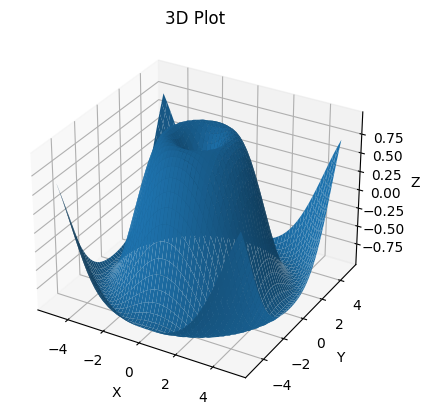

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# create some sample data
x = np.linspace(-5, 5, 50)
y = np.linspace(-5, 5, 50)
X, Y = np.meshgrid(x, y)
Z = np.sin(np.sqrt(X**2 + Y**2))

# create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z)

# set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Plot')

plt.show()

In [2]:
import os
import pandas as pd

PATH = os.getcwd()
df_param_combos = pd.read_csv(PATH + '/Regression Only Results/GridSearch Data.csv')

In [5]:
df_param_combos['param_C'][df_param_combos['param_gamma'] == 'auto']

1       1
3       1
5       1
7       1
9       1
       ..
791    96
793    96
795    96
797    96
799    96
Name: param_C, Length: 400, dtype: int64

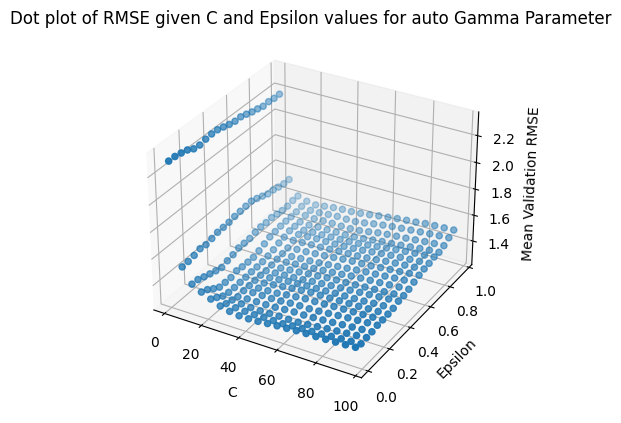

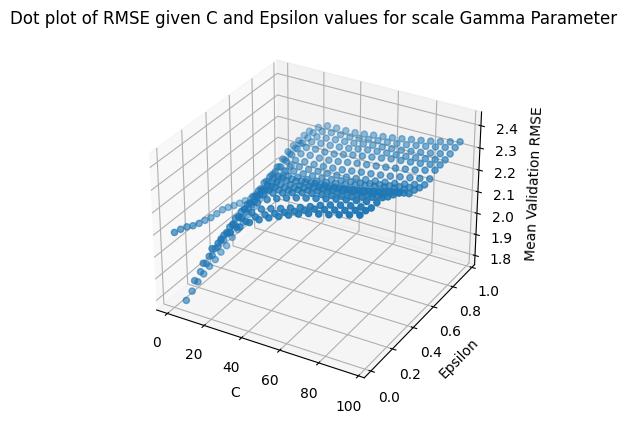

In [34]:
gammas = ('auto', 'scale')

# Creating pltos for both of the 'auto' and 'scale' gammas
for gamma in gammas:
    # x y and z
    x_grid = df_param_combos['param_C'][df_param_combos['param_gamma'] == gamma]
    y_grid = df_param_combos['param_epsilon'][df_param_combos['param_gamma'] == gamma]
    z_grid = df_param_combos['mean_test_score'][df_param_combos['param_gamma'] == gamma]*(-1)

    # Create the figure
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x_grid, y_grid, z_grid)
    ax.set_title('Dot plot of RMSE given C and Epsilon values for %s Gamma Parameter' %(gamma))
    ax.set_xlabel('C')
    ax.set_ylabel('Epsilon')
    ax.set_zlabel('Mean Validation RMSE')

    fig.savefig(PATH + '/Figures/RMSE plot for gamma %s.png' %(gamma))

In [16]:
gammas = ('auto', 'scale')
for gamma in gammas:
    print(gamma)


auto
scale


In [29]:
fig.clf()

In [30]:
fig

<Figure size 640x480 with 0 Axes>